# COGS 108 - EDA Checkpoint

# Names

- Jiayi Zhao
- Wenbo Hu
- Yunyi Huang
- Xiaotong Zeng

<a id='research_question'></a>
# Research Question

Is there a statistically significant relationship between the scale (burning area) of wildfire and climate variables in California that are associated with global warming such as relative humidity level, temperature, wind speed, and precipitation? Additionally, how can we utilize these climate variables to predict the wildfire event in California and the scale of wildfire?

# Setup

### Import Necessary Libraries

In [1]:
# Import pandas to read csv file and manage heterogenous data
import pandas as pd

# Import numpy to store numeric information and perform numerical analysis
import numpy as np

# Import seaborn and matplotlib to visualize data
import seaborn as sns
import matplotlib.pyplot as plt

# Import numpy to store numeric information and perform numerical analysis
import numpy as np

# Import seaborn and matplotlib to visualize data
import seaborn as sns
import matplotlib.pyplot as plt

#Import scipy to gather statistics
from scipy import stats

# Import patsy and statsmodels for regression analysis
import patsy
import statsmodels.api as sm

# Import math for using some math function
import math

import warnings

import shutil

import os

### Import the three data sets that we need

In [ ]:
# Load the California wildfire incidents data set in data frame
# We get this data set from Kaggle (https://www.kaggle.com/ananthu017/california-wildfire-incidents-20132020)
wildfire = pd.read_csv("California_Fire_Incidents.csv")


# Load the US weather station ID data set in data frame
# We get the Integrated Surface Data (ISD) station list from ncdc.noaa.gov
station = pd.read_csv("https://www1.ncdc.noaa.gov/pub/data/noaa/isd-history.csv")


# Load the US weather daily data set from 2013 to 2019 in data frame
# We get this data from ncei.noaa.gov and download to the local.
# (https://www.ncei.noaa.gov/data/global-summary-of-the-day/archive/)
for dirname, _, filenames in os.walk('/Users/wenbohu/Desktop/Weather'):
    for filename in filenames:
        print((os.path.join(dirname, filename)))
        
# get all subdiretory of all tables
file_dict ={}
for path, dirs, files in os.walk('/Users/wenbohu/Desktop/Weather', topdown=False):
    file_dict[path]=files
    
paths = list(file_dict.keys())

events = []
for path in paths:
    events += [os.path.join(path,file) for file in file_dict[path]]
    

# Data Cleaning

Since we have three data set, we choose to clean them seperatly and then merge these dataset by locations.

### First, we clean the California wildfire incidents data set


Since we only need the dates, acres burned (scale), and county name for the following analysis, we update these information back to `wildfire`.

In [ ]:
# delete the irrelevant columns
wildfire = wildfire[['AcresBurned','Started','Counties', 'Latitude', 'Longitude']]

# change the started time into date
wildfire['Started'] = [x[0:10] for x in wildfire['Started']]

# change the 'Started' column name into 'Date'
wildfire = wildfire.rename({'Started':'Date'}, axis='columns')

#drop the null values 
wildfire['Latitude'] = wildfire['Latitude'].apply(lambda x: np.nan if x == 0 else x)
wildfire = wildfire.dropna().reset_index(drop=True) 


Now take a look on the `wildfire` dataframe

In [ ]:
wildfire.head()

### Second, clean the Integrated Surface Data (ISD) station list

In [ ]:
# Since the weather station ID is a combination of column 'USAF' and 'WBAN',
# we combine these two columns into a new column called 'ID'
station['ID']= station['USAF'].astype(str) + station['WBAN'].astype(str)

# we only analyze California weather
station = station[(station['STATE']=='CA') & (station['CTRY']=='US')].reset_index(drop=True)

# station only need to include the ID and the nameof the station
pd.set_option("max_rows", None)

Now take a look on the `station` dataframe

In [ ]:
station.head()

### Thrid, we merge the`wildfire` and `station` dataframes by matching the LATITUDE and LONGTITUDE of the wildfire incident locations and weather stations. 
We compare each error index (0.1, 0.2, 0.3, 0.5) in order to find which diameter we should choose for more unique stations is determined.

In [ ]:
IDlist = []
for i,j in wildfire.iterrows():
    before = len(IDlist)
    for a,b in station.iterrows():
        #about 50km * 40km (just for first time test then tried 0.3, 0.1, and 0.2)
        if (((b['LAT'] <= j['Latitude'] + 0.2) and (b['LAT'] >= j['Latitude'] - 0.2)) 
        and (( b['LON'] <= j['Longitude'] + 0.2) and ( b['LON'] >= j['Longitude'] - 0.2))):
            IDlist.append(b['ID'])
            break
    after = len(IDlist)
    if (before == after):
        IDlist.append("Not_Found")

In [ ]:
# 0.5-95 0.3-119 0.1-119 0.2-127(THIS IS THE BEST!!!!)
# when 0.1 it's also 119 but lots of not found values
unique = []
for x in IDlist:
    if x not in unique:
        unique.append(x)
print(len(unique))

Then, we create a dataframe called `matched_wildfire` that consists the scale, date, county name, latitude, and longitude of the wildfire incidents and the weather station ID in that incident area.

In [ ]:
IDlist = []
row_fire = []
row_ID =[]

# create a new dataframe to store these matched data
matched_wildfire = pd.DataFrame(columns=wildfire.columns)

# iterate the rows in wildfire and station to find the matched data
for i,j in wildfire.iterrows():
    for a,b in station.iterrows():
        if (((b['LAT'] <= j['Latitude'] + 0.2) and (b['LAT'] >= j['Latitude'] - 0.2)) 
        and (( b['LON'] <= j['Longitude'] + 0.2) and ( b['LON'] >= j['Longitude'] - 0.2))):
            IDlist.append(b['ID'])
            row_ID.append(b['ID'])
            row_fire.append(list(j))
            break
            
matched_wildfire = matched_wildfire.append(pd.DataFrame(row_fire,columns=wildfire.columns))
matched_wildfire = matched_wildfire.assign(ID=row_ID)

Now, take a look on the `matched_wildfire`

In [ ]:
matched_wildfire.head()

### Fourth, using the `matched_wildfire` data frame merge with the weather dataset from 2013 to 2019 so that every wildfire incident has the weather data of that day. 

Take a brief look on how the dataset of one station in the weather dataset in 2013 looks like

In [ ]:
example = pd.read_csv("/Users/wenbohu/Desktop/Weather/2013/40854099999.csv")
example.head()

Loop the `matched_wildfire` and find the weather data with the matched date and station ID

In [ ]:
# Get the weather information of wildfire start date 
row_weather = []
join_id = []
num = 1

# create a data frame to store the weather data
weather = pd.DataFrame(columns = example.columns)

for i, j in matched_wildfire.iterrows():
    for file in events:
        if num in join_id:
            break
        if (file[-15:-4] == j['Station_ID']):
            temp = pd.read_csv(file)
            for a, b in temp.iterrows():
                if (b["DATE"] == j['Date']):
                    row_weather.append(list(b))
                    join_id.append(num)
                    break 
    num += 1

Append these matched weather data to `weather`

In [ ]:
weather = pd.DataFrame(columns = example.columns)
weather = weather.append(pd.DataFrame(row_weather, columns = example.columns))
weather = weather.assign(Join_ID = join_id)

Now, take a look on the *weather*

In [ ]:
weather.head()

Merge `matched_wildfire` and `weather`, and store this merge dataset in local as a csv file

In [ ]:
dataframe = matched_wildfire.merge(weather, on = 'Join_ID')
dataframe.to_csv('/Users/wenbohu/Desktop/df.csv')

### Lastly, import and clean this final data frame

The weather variable columns decription:
 - TMP: Mean temperature for the day in degrees Fahrenheit to tenths. Missing = 9999.9
 - DEWP: Mean dew point for the day in degrees Fahrenheit to tenths. Missing = 9999.9
 - WDSD: Mean wind speed for the day in knots to tenths. Missing = 999.9
 - PRCP: Total precipitation (rain and/or melted snow) reported during the day in inches and hundredths; will usually not end with

In [2]:
df = pd.read_csv('df.csv')

df = df[['AcresBurned', 'Date', 'Counties','TEMP','DEWP','WDSP','PRCP']] 

# By the column description, we replace the missing value (9999.9 or 999.9) with np.nan
df['TEMP'] = df['TEMP'].replace(9999.9, np.nan, regex=True) 
df['DEWP'] = df['DEWP'].replace(9999.9, np.nan, regex=True) 
df['WDSP'] = df['WDSP'].replace(999.9, np.nan, regex=True) 
# Drop the NAN value
df = df.dropna(subset=['TEMP','DEWP','WDSP'])

# convert the temperature and the dewpoint from Fahrenheit to Celsius
df['TEMP'] = 5.0 / 9.0 * (df['TEMP'] - 32.0)
df['DEWP'] = 5.0 / 9.0 * (df['DEWP'] - 32.0)

# calculate saturation vapor pressure(Es) and actual vapor pressure(E) in millibars.
df['Es'] = 6.11*10.0**(7.5*df['TEMP']/(237.7+df['TEMP']))
df['E'] = 6.11*10.0**(7.5*df['DEWP']/(237.7+df['DEWP']))

# Once you have the saturation vapor pressure and the actual vapor pressure, 
# relative humidity(RH) can be computed by dividing the actual vapor pressure by the saturation vapor pressure 
# and then multiplying by 100 to convert the quantity to a percent.
df ['RelaHumPct'] = (df['E']/df['Es'])*100

# Rename the columns
df = df.rename(columns={'Counties':'County','TEMP':'Temp','DEWP':'DewPt','WDSP': 'WindSpd','PRCP':'Precipitation'})
df = df[['AcresBurned','Date','County','Temp','WindSpd','Precipitation','RelaHumPct']]


#### The Final Dataframe

Description on the columns of the final dataframe:
 - AcresBurned: The area of the wildfire incident burns in degree acre
 - Date: The date of the wildfire incident
 - County: The county where the wildfire incident belongs
 - Temp: Mean temperature for the day in degrees Celsius
 - DewPt: Mean dew point for the day in degrees Celsius
 - WindSpd: Mean wind speed for the day in knots to tenths.
 - Precipitation: Total precipitation (rain and/or melted snow) reported during the day in inches and hundredths; will usually not end with
 - RelaHumPct: Relative humidity for the day in perpercentage

In [3]:
df.head()

,AcresBurned,Date,County,Temp,WindSpd,Precipitation,RelaHumPct
1,712.0,2013-07-19,Kern,26.944444,13.2,0.0,18.527509
3,305.0,2013-10-04,Butte,19.000000,10.1,0.0,23.086979
4,298.0,2013-06-03,Butte,27.111111,3.5,0.0,35.698961
5,240.0,2013-06-08,Alameda,28.666667,4.0,0.0,35.230183
6,200.0,2013-07-04,Tehama,36.500000,10.0,0.0,19.131822


# Data Analysis & Results (EDA)

## Descriptive Analysis

First, we'll get a sense of what information we have in the df dataset.

In [4]:
# determine the shape of the data
df.shape

(372, 7)

In [5]:
# get descriptive statistics for quantitative variables
df.describe()

,AcresBurned,Temp,WindSpd,Precipitation,RelaHumPct
count,372.000000,372.000000,372.000000,372.000000,372.000000
mean,6147.862903,22.626045,6.004301,0.005376,41.945580
std,42796.625726,5.260780,2.880510,0.074306,17.166863
min,0.000000,2.611111,0.300000,0.000000,6.578408
25%,33.000000,19.041667,4.300000,0.000000,29.354164
50%,78.000000,22.972222,5.400000,0.000000,38.853739
75%,241.750000,26.236111,6.900000,0.000000,53.300922
max,410203.000000,41.222222,22.000000,1.360000,91.355476


In [6]:
# Checking the data type
df.dtypes

AcresBurned      float64
Date              object
County            object
Temp             float64
WindSpd          float64
Precipitation    float64
RelaHumPct       float64
dtype: object

## EDA: Exploratory Data Analysis

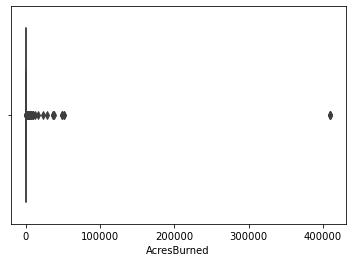

In [7]:
# look at burning areas (in acres) distributions
sns.boxplot(x=df['AcresBurned']);

Here you should see a distribution skewed right, with most burnning area are in few acreas and a few getting many more.
We note that there exist an outlier that had 410203 acres burnning area. This is an interesting data point and something we want to investigate further. What's going on here?

In [8]:
outlier = df[df['AcresBurned'] == df['AcresBurned'].max()]
outlier

,AcresBurned,Date,County,Temp,WindSpd,Precipitation,RelaHumPct
221,410203.0,2018-07-27,Colusa,27.611111,4.5,0.0,27.269169
222,410203.0,2018-07-27,Glenn,27.611111,4.5,0.0,27.269169
223,410203.0,2018-07-27,Lake,27.611111,4.5,0.0,27.269169
224,410203.0,2018-07-27,Mendocino,27.611111,4.5,0.0,27.269169


#### If we Google this date, we see that [Mendocino complex fire affects four counties](https://en.wikipedia.org/wiki/Mendocino_Complex_Fire). It makes sense that the readership increased by 410203 there. 
Before we carry out our analysis, we're going to **remove the repeated three rows and leave with Mendocino. Store this output in `df` again.**

(还有重复的事件发生，都删了）

In [9]:
df = df.drop_duplicates(subset=['Date','AcresBurned'])

Let's take a look at the change in daily cirulation after removing these outliers.

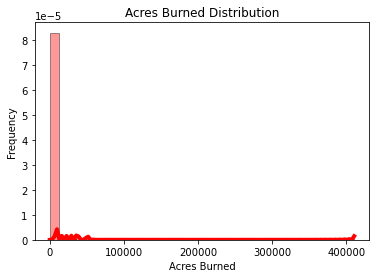

In [10]:
# AcresBurned
ax = sns.distplot(df['AcresBurned'], hist=True, kde=True, 
                  bins=int(len(df['AcresBurned'])/10),
                  color='red',hist_kws={'edgecolor':'black'}, 
                  kde_kws={'linewidth':4})

ax.set(xlabel='Acres Burned', ylabel='Frequency', title='Acres Burned Distribution')
plt.show()

### what happen after removing the outlier for acres burned?

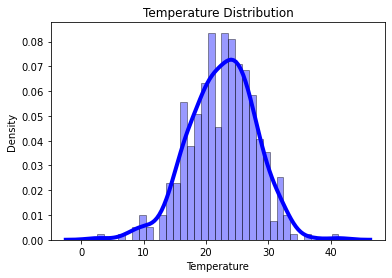

In [11]:
# look at temperature distributions
ax = sns.distplot(df['Temp'], hist=True, kde=True, 
                  bins=int(len(df['Temp'])/10),
                  color='blue',hist_kws={'edgecolor':'black'}, 
                  kde_kws={'linewidth':4})

ax.set(xlabel='Temperature', ylabel='Density', title='Temperature Distribution')
plt.show()

#### Here we see our plot of temperature. **blablabla** 

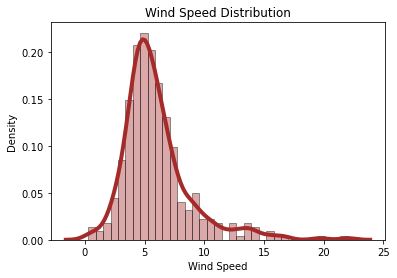

In [12]:
# look at wind speed distributions
ax = sns.distplot(df['WindSpd'], hist=True, kde=True, 
                  bins=int(len(df['WindSpd'])/10),
                  color='brown',hist_kws={'edgecolor':'black'}, 
                  kde_kws={'linewidth':4})

ax.set(xlabel='Wind Speed', ylabel='Density', title='Wind Speed Distribution')
plt.show()

#### (Need Correction on Analysis！！) For Wind Speed, the median clusters around 5.4 and the data seems to be skewed to the right with a few outliers that above 10.

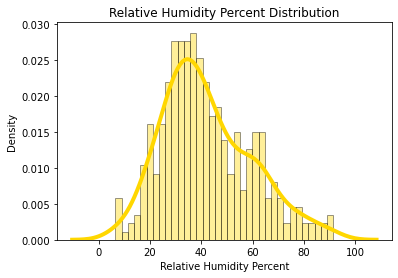

In [13]:
# look at air relative humidity (in percentage) distributions
ax = sns.distplot(df['RelaHumPct'], hist=True, kde=True, 
                  bins=int(len(df['RelaHumPct'])/10),
                  color='gold',hist_kws={'edgecolor':'black'}, 
                  kde_kws={'linewidth':4})

ax.set(xlabel='Relative Humidity Percent', ylabel='Density', title='Relative Humidity Percent Distribution')
plt.show()

#### (CORRECTION!!) For Relative Humidity Percent, the median clusters around 39 and the data seems to follow a weak normal distribution with a light skew to the right having a few outliers that above 85.

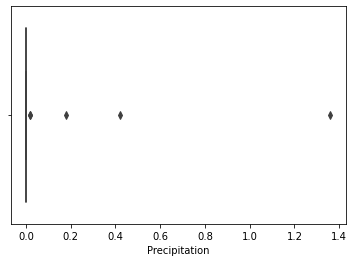

In [14]:
sns.boxplot(x=df['Precipitation']);

#### (CORRECTION!!)  For Precipitatin, the median is 0 and the data is skewed to the right due to a few days of rain. 

## Relationship between variables

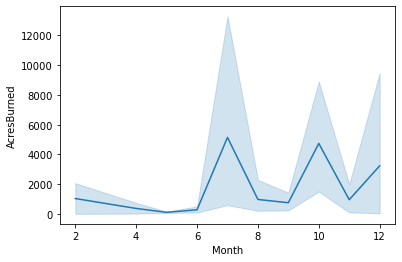

In [15]:
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
sns.lineplot(x = 'Month', y = 'AcresBurned', data = df);


blablablabla

### Acres burned V.S. Temperature

Plot the relationship between the acres burned and temperatures of the wildfire incidents across the years in this dataset to get a sense of what's going on.

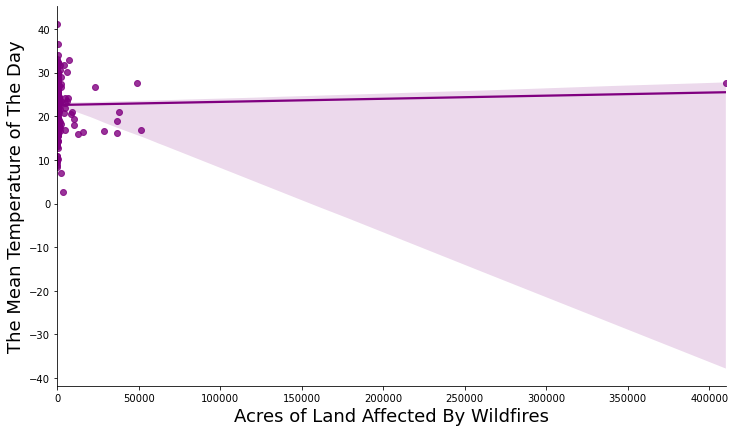

In [16]:
# Relationship between the arces burned and temperatures of wildfire incidents
sns.lmplot(x = 'AcresBurned',
           y = 'Temp',
           data = df, 
           fit_reg = True, 
           height = 6,
           aspect = 1.7, 
           line_kws={'color': 'purple'},
           scatter_kws={'color': 'purple'})
plt.xlabel('Acres of Land Affected By Wildfires', size=18)
plt.ylabel('The Mean Temperature of The Day', size=18)
plt.title('');

What you should see here is that there appears to be no relationship but note that there are outliers in acres burned, where acres burned is much higher than number of temperature. Overall, most of the data are clustered around zero acres. This is because the distributions of acres burned is skewed right. This suggests that we may need to transform these data to use linear regression to ensure that the large outlier values are not driving our relationship.

So, as discussed in class: **Apply a log10-transformation the AcresBurned count data, with an offset of 0.1** This will shift the values away from being centered near zero when put on the log scale. Store this in a new column `AcresBurned_log10`.

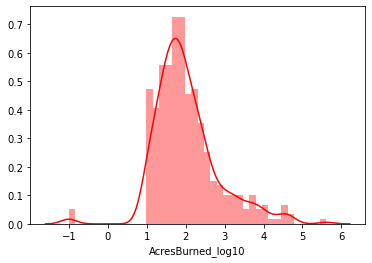

In [17]:
df['AcresBurned_log10'] = np.log10(df['AcresBurned'] + 0.1)

sns.distplot(df['AcresBurned_log10'], 
             kde=True, bins=40, color="red");

Well, the distribution should appear less skewed...but what's going on down around -1? Well, this is because there were zeroes in the original dataset (see below). Due to this we used an offset of 0.1 in the log transformation above. These zeroes all show up at -1 as the $log_{10}(0+0.1) = -1$. 

In [18]:
# this should show you all of the papers with zero pulitzer prizes
df[df['AcresBurned_log10'] < 0]

,AcresBurned,Date,County,Temp,WindSpd,Precipitation,RelaHumPct,Month,AcresBurned_log10
101,0.0,2016-04-19,Los Angeles,20.111111,9.6,0.00,20.252206,4,-1.0
219,0.0,2017-05-19,San Luis Obispo,20.000000,6.1,0.00,32.720699,5,-1.0
220,0.0,2017-02-07,Butte,13.722222,19.7,1.36,88.698477,2,-1.0


Now it's time to do our analysis!
First, plot the relationship between our two variables of interest - be sure to consider the assumptions of linear regression discussed in class and determine if linear regression is appropriate.
Then, if appropriate, use linear regression to determine the effect of log 10 pulitzer on change in daily circulation and take a look at the results

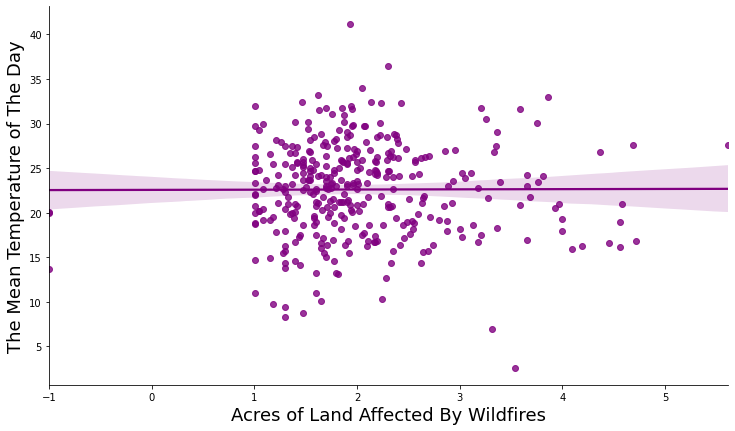

In [19]:
# plot relationship between the total number of Pulitzers and change readership
sns.lmplot(x = 'AcresBurned_log10',
           y = 'Temp',
           data = df, 
           fit_reg = True, 
           height = 6,
           aspect = 1.7, 
           line_kws={'color': 'purple'},
           scatter_kws={'color': 'purple'})
plt.xlabel('Acres of Land Affected By Wildfires', size=18)
plt.ylabel('The Mean Temperature of The Day', size=18)
plt.title('');

In [20]:
# carry out linear regression
acres_temp = df[['Temp', 'AcresBurned_log10']]
acres_temp.columns = ['Temp', 'AcresBurned_log10']

outcome, predictors = patsy.dmatrices('Temp ~ AcresBurned_log10', acres_temp)

# Now use statsmodels to intialize an OLS linear model
# This step initializes the model, and provides the data (but does not actually compute the model)
mod_log = sm.OLS(outcome, predictors)

# fit the model
res_log = mod_log.fit()

# Check out the results
print(res_log.summary())

                            OLS Regression Results                            
Dep. Variable:                   Temp   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                  0.003968
Date:                Thu, 25 Feb 2021   Prob (F-statistic):              0.950
Time:                        21:17:23   Log-Likelihood:                -1101.6
No. Observations:                 358   AIC:                             2207.
Df Residuals:                     356   BIC:                             2215.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            22.5523      0.73

Here, we can't directly interpret our $\beta_1$ estimate (`coef`) on our original scale above because we log-transformed our data. In order to interpet $\beta_1$, we would say that for every one unit increase in the number of pulitzers a publication has, the viewership increases by `~(coef/100)`, which here would be (0.31/100)...or 0.0031. That effect is pretty small. This is further reflected in the p-value (0.291), which suggests that we would see these results, or something more extreme due to random chance alone approximately 29.1% of the time.

We can therefore conclude that based on the data we have over these two time periods, there is not a significant relationship between the number of acres burned and temperature. We also know that this analysis is likely failing to take into account the effect of confounders we discussed in class, limiting our confidence in this result.

### Acres burned V.S. Wind Speed

Plot the relationship between the acres burned and wind speed of the wildfire incidents across the years in this dataset to get a sense of what's going on.

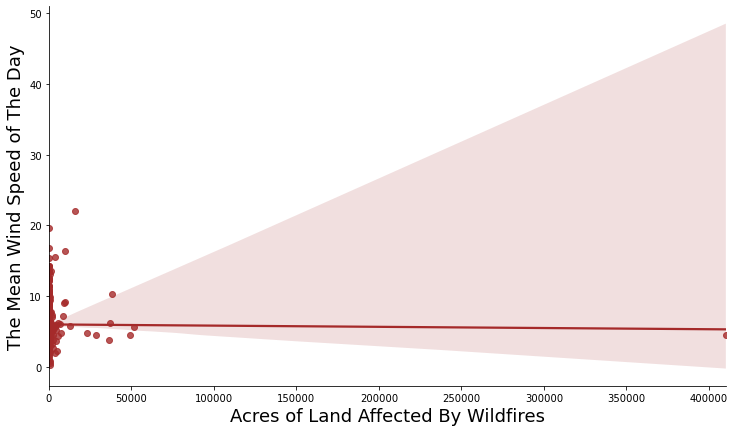

In [21]:
# Relationship between the arces burned and temperatures of wildfire incidents
sns.lmplot(x = 'AcresBurned',
           y = 'WindSpd',
           data = df, 
           fit_reg = True, 
           height = 6,
           aspect = 1.7, 
           line_kws={'color': 'brown'},
           scatter_kws={'color': 'brown'})
plt.xlabel('Acres of Land Affected By Wildfires', size=18)
plt.ylabel('The Mean Wind Speed of The Day', size=18)
plt.title('');

blablablablabla

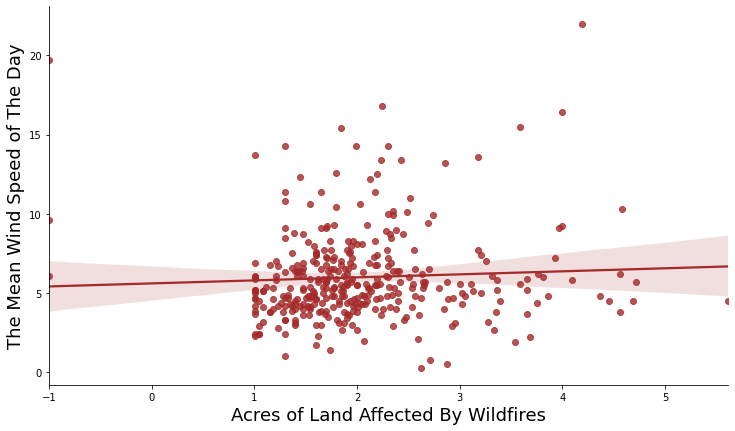

In [22]:
# Relationship between the arces burned and temperatures of wildfire incidents
sns.lmplot(x = 'AcresBurned_log10',
           y = 'WindSpd',
           data = df, 
           fit_reg = True, 
           height = 6,
           aspect = 1.7, 
           line_kws={'color': 'brown'},
           scatter_kws={'color': 'brown'})
plt.xlabel('Acres of Land Affected By Wildfires', size=18)
plt.ylabel('The Mean Wind Speed of The Day', size=18)
plt.title('');

In [23]:
# carry out linear regression
acres_temp = df[['WindSpd', 'AcresBurned_log10']]
acres_temp.columns = ['WindSpd', 'AcresBurned_log10']

outcome, predictors = patsy.dmatrices('WindSpd ~ AcresBurned_log10', acres_temp)

# Now use statsmodels to intialize an OLS linear model
# This step initializes the model, and provides the data (but does not actually compute the model)
mod_log = sm.OLS(outcome, predictors)

# fit the model
res_log = mod_log.fit()

# Check out the results
print(res_log.summary())

                            OLS Regression Results                            
Dep. Variable:                WindSpd   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.108
Date:                Thu, 25 Feb 2021   Prob (F-statistic):              0.293
Time:                        21:17:24   Log-Likelihood:                -882.86
No. Observations:                 358   AIC:                             1770.
Df Residuals:                     356   BIC:                             1777.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             5.6092      0.39

blbalbalbalba

### Acres burned V.S. Relative Humidity Percentage

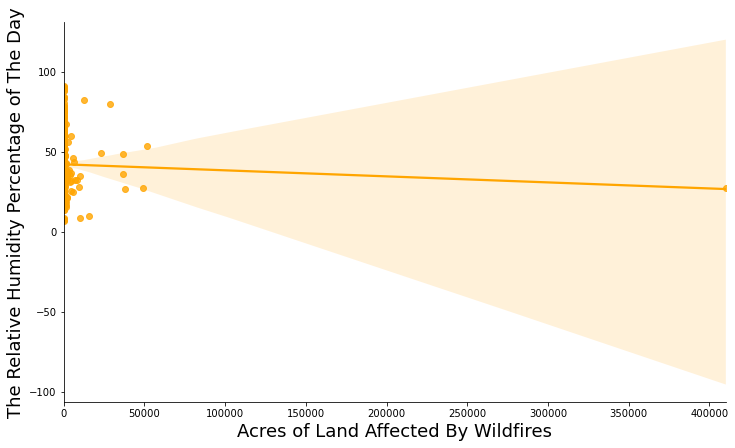

In [24]:
sns.lmplot(x = 'AcresBurned',
           y = 'RelaHumPct',
           data = df, 
           fit_reg = True, 
           height = 6,
           aspect = 1.7, 
           line_kws={'color': 'orange'},
           scatter_kws={'color': 'orange'})
plt.xlabel('Acres of Land Affected By Wildfires', size=18)
plt.ylabel('The Relative Humidity Percentage of The Day', size=18)
plt.title('');

blablabla

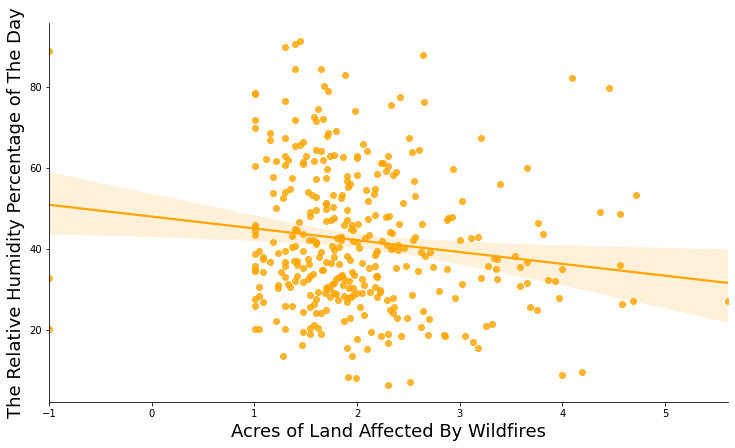

In [25]:
sns.lmplot(x = 'AcresBurned_log10',
           y = 'RelaHumPct',
           data = df, 
           fit_reg = True, 
           height = 6,
           aspect = 1.7, 
           line_kws={'color': 'orange'},
           scatter_kws={'color': 'orange'})
plt.xlabel('Acres of Land Affected By Wildfires', size=18)
plt.ylabel('The Relative Humidity Percentage of The Day', size=18)
plt.title('');

In [26]:
# carry out linear regression
acres_temp = df[['RelaHumPct', 'AcresBurned_log10']]
acres_temp.columns = ['RelaHumPct', 'AcresBurned_log10']

outcome, predictors = patsy.dmatrices('RelaHumPct ~ AcresBurned_log10', acres_temp)

# Now use statsmodels to intialize an OLS linear model
# This step initializes the model, and provides the data (but does not actually compute the model)
mod_log = sm.OLS(outcome, predictors)

# fit the model
res_log = mod_log.fit()

# Check out the results
print(res_log.summary())

                            OLS Regression Results                            
Dep. Variable:             RelaHumPct   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     7.269
Date:                Thu, 25 Feb 2021   Prob (F-statistic):            0.00735
Time:                        21:17:25   Log-Likelihood:                -1522.2
No. Observations:                 358   AIC:                             3048.
Df Residuals:                     356   BIC:                             3056.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            47.9732      2.36

blablablab